### Nuisance Parameters and Normalized Distribution
Parameters necessary to build model but not interesting by themselves are called nuisance parameters. We can write Bayes' theorem for a two parameter model as follows:
$$ p(\theta_1, \theta_2 | y) \propto p(y | \theta_1, \theta_2) p(\theta_1, \theta_2) $$

We can generalise this for more than two parameters as well. Now assume $\theta_2$ is nuisance parameter for our problem. How do we express posterior in terms of $\theta_1$ only? We have to marginalize the posterior over $\theta_2$:
$$ p(\theta_1 | y) = \int p(\theta_1, \theta_2 | y) d\theta_2$$

Hence when we hear about the marginal distribution of parameter x, we must think of the average distribution of x taken over the entire distribution of the other parameters.


In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm

In [5]:
import seaborn as sns

In [3]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 
                 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33,
                 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
                 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99,
                 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84,
                 53.16])

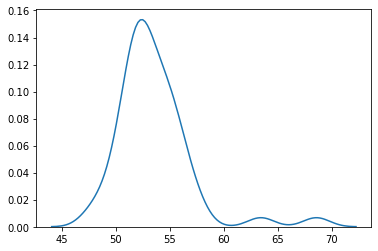

In [6]:
sns.kdeplot(data)

### Gaussian Inferences
Above plot shows Gaussian like distribution except two points distant from the mean, for time being lets assume that it is Gaussian and model it. Since we do not know mean and variance, we must set prior for both of them. A reasonable model could be:

$$ \mu \sim Uniform(l, h) $$
$$ \sigma \sim HalfNormal(\sigma_h) $$
$$ y \sim Normal(\mu, \sigma) $$

In [7]:
with pm.Model() as gaussian_model:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd= 10)
    y = pm.Normal('y', mu=mu, sd = sigma, observed = data)
    
    trace_g = pm.sample(1100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 3200/3200 [00:01<00:00, 2130.18draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faac3d3bba8>,
      dtype=object)

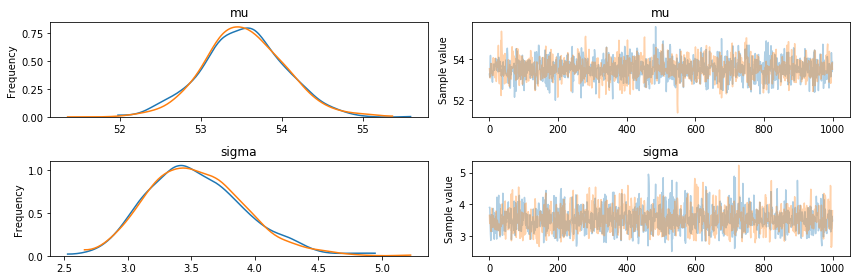

In [9]:
chain_g = trace_g[100:]
pm.traceplot(chain_g)

In [10]:
pm.summary(chain_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.525521,0.501959,0.011198,52.513869,54.513935,1997.832573,0.999684
sigma,3.535798,0.376807,0.008501,2.851506,4.286266,1827.039462,0.999500


### Posterior Predictive Check
We are using posterior to make predictions and those predictions to check the model

In [46]:
with gaussian_model:
    pred_y = pm.sample_ppc(chain_g, 100)

100%|██████████| 100/100 [00:00<00:00, 1262.26it/s]


Text(0.5, 0, '$x$')

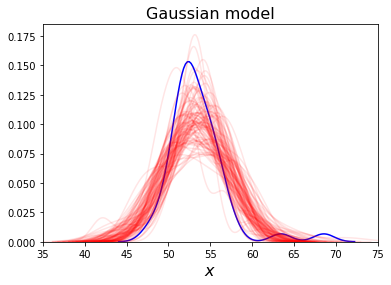

In [47]:
sns.kdeplot(data, c='b')

for i in pred_y['y']:
    sns.kdeplot(i, c = 'r', alpha=0.1)
plt.xlim(35,75)
plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)

### Robust Inferences
We saw in above plot, two pints were not properly fitting in normal curve. One solution is to assume them as outliers, remove them for inference. 
Outliers are all data points below 1.5 times the interquartile range from the lower quartile or 1.5 times the interqurtile range above the upper quartile.
All data points below or above two times the standard deviation of our data should be declared outliers and banished from our data.

### Student t-distribution
Other solution is not to change data(remove outliers), we can change the model. As a genreal rule, Bayesina prefer to to encode assumptions directly in the model by using different prior or likelihoods than through ad-hoc heauristc like outlier removal.
One useful option when dealing with outliers is to use Student's t-distribution for likelihood. 

1. Theoretical distribution when $\nu \le 1$ does not have defined mean(sample mean obviously can be calculated). Intitutively this means the tails of the distribution are so heavy that at any moment, it could happen that we get a sampled value from almost anywhere in real line. 
2. In similar fashion, the variance of this distributios is only defined for values $\nu > 2$. 

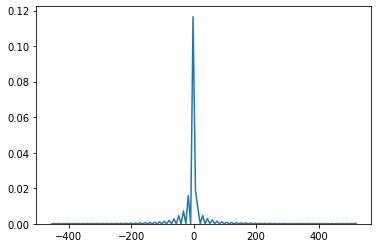

In [50]:
values = []
for i in range(1000):
    values.append(np.mean(stats.t(loc=0, scale = 1, df = 1).rvs(100)))

sns.kdeplot(values)

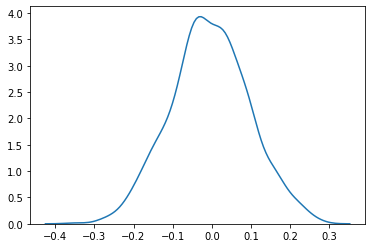

In [51]:
values = []
for i in range(1000):
    values.append(np.mean(stats.t(loc=0, scale = 1, df = 100).rvs(100)))

sns.kdeplot(values)

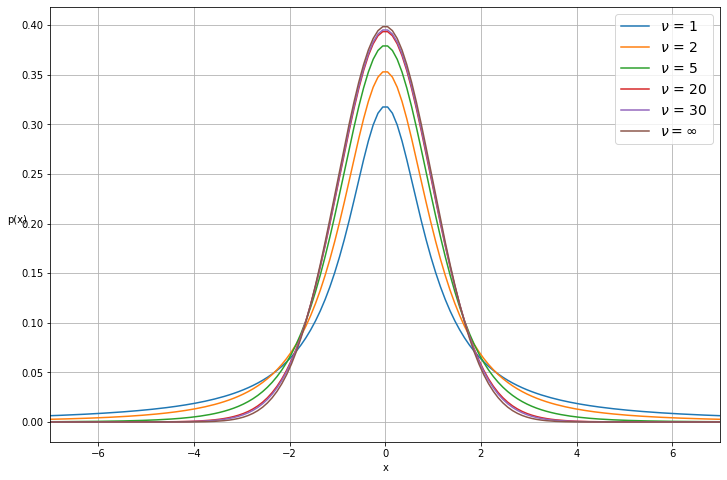

In [58]:
x_values = np.linspace(-10, 10, 200)
plt.figure(figsize=(12,8))

for df in [1,2,5,20, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label = r'$\nu$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label = r'$\nu = \infty$')
plt.xlabel('x')
plt.ylabel('p(x)', rotation = 0)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7)
plt.grid(True)



Using t-distribution, our model can be written as follows
$$ \mu \sim Uniform(l, h) $$
$$ \sigma \sim HalfNormal(\sigma_h) $$
$$ \nu \sim Exponential(\lambda) $$
$$ y \sim StudentT(\mu, \sigma, \nu) $$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma, mu]
Sampling 2 chains: 100%|██████████| 3200/3200 [00:02<00:00, 1488.21draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faaade78dd8>,
      dtype=object)

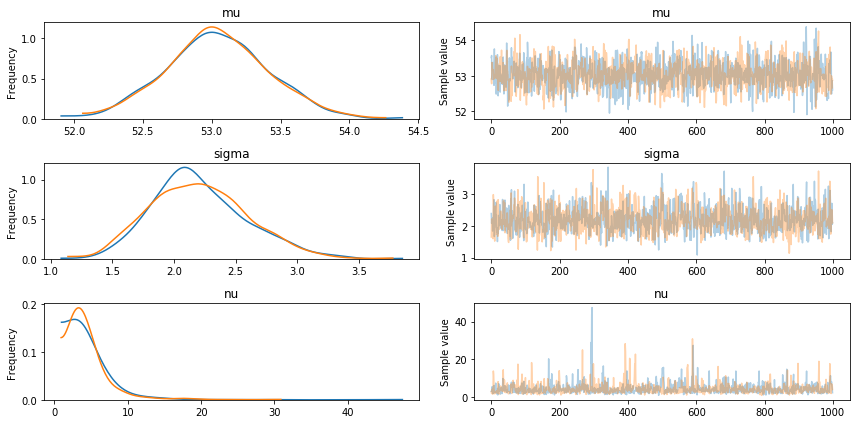

In [63]:
with pm.Model() as model_t:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu = pm.Exponential('nu', 1/30)
    y = pm.StudentT('y', mu=mu, nu = nu, sd=sigma, observed=data)
    
    trace_t = pm.sample(1100)

chain_t = trace_t[100:]
pm.traceplot(chain_t)

In [64]:
pm.summary(chain_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.036311,0.372006,0.010171,52.271427,53.721137,1511.374016,0.999537
sigma,2.204722,0.395815,0.011567,1.489107,2.961387,1272.474611,0.999513
nu,4.572357,3.211916,0.100185,1.107675,9.691445,901.788018,0.999516


In [65]:
pm.summary(chain_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.525521,0.501959,0.011198,52.513869,54.513935,1997.832573,0.999684
sigma,3.535798,0.376807,0.008501,2.851506,4.286266,1827.039462,0.999500


Estimation of $\mu$ is similar in both cases. The estimation of $\sigma$ changed from ~3.5 to ~2.2. This is consequence of the Student t-distribution giving less weight ( getting less shocked) by values away from mean. 

Lets see posterior predictive check

100%|██████████| 100/100 [00:00<00:00, 1191.94it/s]


Text(0.5, 0, '$x$')

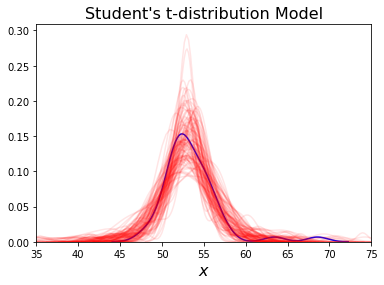

In [67]:
with model_t:
    y_pred = pm.sample_ppc(chain_t, 100)
    
sns.kdeplot(data, c= 'b')
for i in y_pred['y']:
    sns.kdeplot(i, c='r', alpha=0.1)
plt.xlim(35, 75)
plt.title("Student's t-distribution Model", fontsize=16)
plt.xlabel('$x$', fontsize=16)